# Data Collection
### Using Yahoo! Finance API to collect data about Microsoft Stock Prices.

In [1]:
import yfinance as yf 

msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

In [2]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055654,0.063838,0.055654,0.061109,1031788800,0.0,0.0
1986-03-14,0.061109,0.064383,0.061109,0.063292,308160000,0.0,0.0
1986-03-17,0.063292,0.064929,0.063292,0.064383,133171200,0.0,0.0
1986-03-18,0.064383,0.064929,0.062201,0.062746,67766400,0.0,0.0
1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.0,0.0


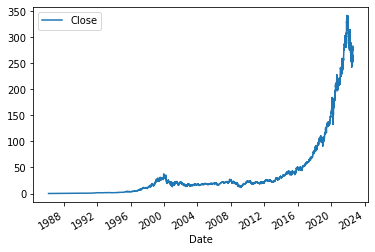

In [3]:
msft_hist.plot.line(y="Close", use_index=True);

### Checking if there is any NaN value 

In [4]:
msft_hist.isnull().sum() 

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

### Preparing the data for machine learning 

In [5]:
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

data["Target"].value_counts()

1.0    4637
0.0    4535
Name: Target, dtype: int64

In [6]:
data.head(5)

,Actual_Close,Target
Date,,
1986-03-13,0.061109,NaN
1986-03-14,0.063292,1.0
1986-03-17,0.064383,1.0
1986-03-18,0.062746,0.0
1986-03-19,0.061655,0.0


In [7]:
msft_prev = msft_hist.shift(1)

In [8]:
msft_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055654,0.063838,0.055654,0.061109,1.031789e+09,0.0,0.0
1986-03-17,0.061109,0.064383,0.061109,0.063292,3.081600e+08,0.0,0.0
1986-03-18,0.063292,0.064929,0.063292,0.064383,1.331712e+08,0.0,0.0
1986-03-19,0.064383,0.064929,0.062201,0.062746,6.776640e+07,0.0,0.0


In [9]:
predictors = ["Close", "High", "Low", "Open", "Volume"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [10]:
data.head(5)

,Actual_Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
1986-03-14,0.063292,1.0,0.061109,0.063838,0.055654,0.055654,1.031789e+09
1986-03-17,0.064383,1.0,0.063292,0.064383,0.061109,0.061109,3.081600e+08
1986-03-18,0.062746,0.0,0.064383,0.064929,0.063292,0.063292,1.331712e+08
1986-03-19,0.061655,0.0,0.062746,0.064929,0.062201,0.064383,6.776640e+07
1986-03-20,0.060018,0.0,0.061655,0.063292,0.061109,0.062746,4.789440e+07


# Training Machine Learning Model

## Random Forest Regression

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [13]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

In [14]:
import pandas as pd

In [15]:
preds = pd.Series(preds, index=test.index)
preds

Date
2022-03-11    1.0
2022-03-14    1.0
2022-03-15    1.0
2022-03-16    1.0
2022-03-17    1.0
             ... 
2022-07-28    1.0
2022-07-29    1.0
2022-08-01    1.0
2022-08-02    1.0
2022-08-03    1.0
Length: 100, dtype: float64

In [16]:
precision_score(test["Target"], preds)*100

50.57471264367817

In [17]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis =1)
combined

,Target,Predictions
Date,,
2022-03-11,0.0,1.0
2022-03-14,0.0,1.0
2022-03-15,1.0,1.0
2022-03-16,1.0,1.0
2022-03-17,1.0,1.0
...,...,...
2022-07-28,1.0,1.0
2022-07-29,1.0,1.0
2022-08-01,0.0,1.0


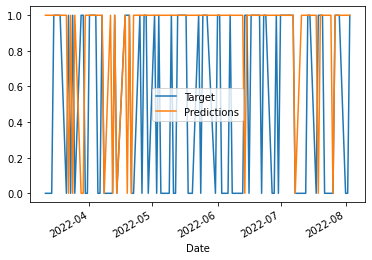

In [18]:
combined.plot();

### Creating a Backtesting Engine

In [19]:
def backtest(data, model, predictors, start=1000, step=200):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [20]:
predictions = backtest(data, model, predictors)

### Improving the accuracy of the model

In [21]:
precision_score(predictions["Target"], predictions["Predictions"])*100

53.733528550512446

In [22]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [23]:
data["weekly_mean"] = weekly_mean["Close"]/data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"]/data["Close"]
data["annual_mean"] = annual_mean["Close"]/ data["Close"]

data["annual_weekly_mean"] = data["annual_mean"]/data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"]/data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"]/data["Close"]
data["high_close_ratio"] = data["High"]/data["Close"]
data["low_close_ratio"] = data["Low"]/data["Close"]
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean","annual_weekly_mean","annual_quarterly_mean","weekly_trend","open_close_ratio","high_close_ratio","low_close_ratio"]

In [24]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [25]:
precision_score(predictions["Target"], predictions["Predictions"])*100

58.46867749419954

## Linear Regression

In [26]:
data.head()

,Actual_Close,Target,Close,High,Low,Open,Volume,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,,,,
1986-03-14,0.063292,1.0,0.061109,0.063838,0.055654,0.055654,1.031789e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.910720,1.044650,0.910720
1986-03-17,0.064383,1.0,0.063292,0.064383,0.061109,0.061109,3.081600e+08,NaN,NaN,NaN,NaN,NaN,NaN,0.965519,1.017250,0.965519
1986-03-18,0.062746,0.0,0.064383,0.064929,0.063292,0.063292,1.331712e+08,NaN,NaN,NaN,NaN,NaN,NaN,0.983042,1.008474,0.983042
1986-03-19,0.061655,0.0,0.062746,0.064929,0.062201,0.064383,6.776640e+07,NaN,NaN,NaN,NaN,NaN,NaN,1.026095,1.034791,0.991305
1986-03-20,0.060018,0.0,0.061655,0.063292,0.061109,0.062746,4.789440e+07,NaN,NaN,NaN,NaN,NaN,NaN,1.017698,1.026547,0.991151


In [27]:
data.isnull().sum()

Actual_Close               0
Target                     0
Close                      0
High                       0
Low                        0
Open                       0
Volume                     0
weekly_mean                6
quarterly_mean            89
annual_mean              364
annual_weekly_mean       364
annual_quarterly_mean    364
weekly_trend               7
open_close_ratio           0
high_close_ratio           0
low_close_ratio            0
dtype: int64

In [28]:
data_clean = data.dropna()
data_clean.head()

,Actual_Close,Target,Close,High,Low,Open,Volume,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,,,,
1987-08-21,0.233526,1.0,0.229706,0.230798,0.223705,0.223705,82051200.0,0.978623,0.991173,0.566203,0.578571,0.571246,0.571429,0.973873,1.004753,0.973873
1987-08-24,0.243892,1.0,0.233526,0.236254,0.229160,0.229160,68976000.0,0.971962,0.976310,0.558964,0.575089,0.572528,0.714286,0.981307,1.011681,0.981307
1987-08-25,0.250440,1.0,0.243892,0.244984,0.230252,0.233526,97747200.0,0.941834,0.936378,0.537234,0.570413,0.573737,0.714286,0.957495,1.004474,0.944070
1987-08-26,0.252077,1.0,0.250440,0.254805,0.243347,0.246075,185961600.0,0.931216,0.913470,0.525224,0.564019,0.574977,0.714286,0.982569,1.017428,0.971677
1987-08-27,0.252622,1.0,0.252077,0.257533,0.249348,0.250440,114105600.0,0.939085,0.909439,0.523871,0.557853,0.576038,0.714286,0.993507,1.021644,0.989176


In [29]:
data_clean.isnull().sum()

Actual_Close             0
Target                   0
Close                    0
High                     0
Low                      0
Open                     0
Volume                   0
weekly_mean              0
quarterly_mean           0
annual_mean              0
annual_weekly_mean       0
annual_quarterly_mean    0
weekly_trend             0
open_close_ratio         0
high_close_ratio         0
low_close_ratio          0
dtype: int64

In [30]:
X = data_clean.drop("Target", axis=1)
y = data_clean["Target"]

print('Shape of X = ', X.shape)
print('Shape of y = ', y.shape)

Shape of X =  (8808, 15)
Shape of y =  (8808,)


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=51)

In [33]:
print('Shape of y = ', X_train.shape)
print('Shape of y = ', X_test.shape)
print('Shape of y = ', y_train.shape)
print('Shape of y = ', y_test.shape)

Shape of y =  (7046, 15)
Shape of y =  (1762, 15)
Shape of y =  (7046,)
Shape of y =  (1762,)



### Feature Scaling

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Building Model

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [38]:
lr.coef_

array([ 9.00875408e+00, -5.04175650e+00, -4.39713193e+00, -2.40066165e+00,
        2.84099309e+00, -5.99103327e-03,  1.09716354e-02,  6.12927642e-03,
       -4.62355592e-02,  2.49873832e-02,  1.67313134e-02,  1.46800781e-03,
       -6.75444949e-02,  6.75063919e-02,  4.45128326e-02])

In [39]:
lr.intercept_

0.5049673573658813

In [40]:
lr.predict(X_test)

array([0.50396053, 0.53039031, 0.52271611, ..., 0.52117248, 0.46107489,
       0.52350934])

In [41]:
lr.score(X_test,y_test)*100

13.27003878031846

## Polynomial Regression 

In [42]:
from sklearn.preprocessing import PolynomialFeatures

In [43]:
poly_reg = PolynomialFeatures(degree = 2)
poly_reg.fit(X_train)
X_train_poly = poly_reg.transform(X_train)
X_test_poly = poly_reg.transform(X_test)

In [44]:
lr.fit(X_train_poly,y_train)
lr.predict(X_test_poly)
lr.score(X_test_poly,y_test)*100

13.727026263335084

## Ridge and Lasso Regression

In [45]:
from sklearn.linear_model import Ridge,Lasso

In [46]:
rd = Ridge(alpha = 1)
rd.fit(X_train,y_train)
rd.predict(X_test)
rd.score(X_test,y_test)*100

12.700609982694077

In [47]:
ls = Lasso(alpha = 1)
ls.fit(X_train,y_train)
ls.score(X_test,y_test)*100

-0.02997566404310259

# Best score is given by Random forest i.e 58.15%